In [1]:
%env GEOMSTATS_BACKEND=pytorch

env: GEOMSTATS_BACKEND=pytorch


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")  

import os
import numpy as np
import torch
from einops import rearrange
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')


from scipy.spatial.transform import Rotation
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

from utils.plotting import plot_so3
from utils.optimal_transport import so3_wasserstein as wasserstein
from foldflow.utils.so3_helpers import norm_SO3, expmap
from utils.so3_cfm import SO3OptimalTransportConditionalFlowMatcher
from so3_experiments.models.models import PMLP

from torch.utils.data import DataLoader
from data.datasets import SpecialOrthogonalGroup

from geomstats._backend import _backend_config as _config
_config.DEFAULT_DTYPE = torch.cuda.FloatTensor 

savedir = "models/so3_synthetic"
os.makedirs(savedir, exist_ok=True)

INFO: Using pytorch backend


In [4]:
# import sys
# sys.path.append("..")  

# import os
# import torch
# import numpy as np
# import importlib
# from einops import rearrange
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# import warnings
# warnings.filterwarnings('ignore')

# from scipy.spatial.transform import Rotation
# from geomstats.geometry.special_orthogonal import SpecialOrthogonal


# from FoldFlow.utils.plotting import plot_so3
# from FoldFlow.so3.so3_helpers import norm_SO3, expmap
# import FoldFlow.so3.so3_flow_matching
# from FoldFlow.so3.so3_flow_matching import SO3OptimalTransportConditionalFlowMatcher
# from FoldFlow.utils.optimal_transport import so3_wasserstein as wasserstein
# from so3_experiments.models.models import PMLP


# from torch.utils.data import DataLoader
# from data.datasets import SpecialOrthogonalGroup

# from geomstats._backend import _backend_config as _config
# _config.DEFAULT_DTYPE = torch.cuda.FloatTensor 

# import pandas as pd

# savedir = "models/so3_synthetic"
# os.makedirs(savedir, exist_ok=True)

cuda:0
size of toy dataset:  50000


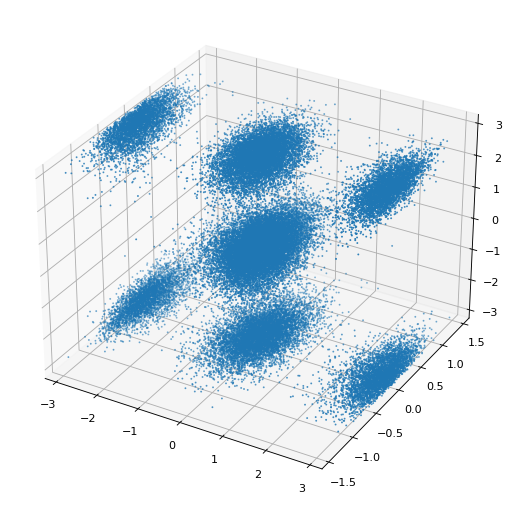

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Load toy dataset
data = np.load('data/orthogonal_group.npy')
print('size of toy dataset: ', len(data))

fig = plot_so3(data)
plt.savefig('figs/so3_synthetic_data.png', dpi=300)
plt.show()

### Dataloader

In [8]:
# load data
trainset = SpecialOrthogonalGroup(split="train")
trainloader = DataLoader(
    trainset, batch_size=1024, shuffle=True, num_workers=0
)

valset = SpecialOrthogonalGroup(split="valid")
valloader = DataLoader(
    valset, batch_size=256, shuffle=False, num_workers=0
)

testset = SpecialOrthogonalGroup(split="test")
testloader = DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=0
)

### OT CFM

This is an SO(3) OTCFM. It draws samples from $\pi(r_0, r_1)$ and calculates the flow at $r_t$:
        $$u_t(r_t | r_0, r_1) = \log_{r_t}(r_0)/t$$

In [9]:
so3_group = SpecialOrthogonal(n=3, point_type="matrix")
FM = SO3OptimalTransportConditionalFlowMatcher(manifold=so3_group)

### Loss Function

The final loss corresponds to equation (5) in the paper:

$$\mathcal{L}_{\mathrm{foldflowot},-\mathrm{SO(3)}}(\theta) = \mathbb{E}_{t\sim \mathcal{U}(0,1), \bar{\pi}(r_0, r_1), \rho_t(r_t | r_0, r_1)} \left \|v_\theta(t, r_t) - \log_{r_t}(r_0)/t\right\|_{\mathrm{SO(3)}}^2.$$

In [10]:
def loss_fn(v, u, x):
    res = v - u
    norm = norm_SO3(x, res) # norm-squared on SO(3)
    loss = torch.mean(norm, dim=-1)
    return loss

### ODE Inference

In [11]:
# ODE inference on SO(3)
def inference(model, xt, t, dt):
    with torch.no_grad():
        vt = model(torch.cat([xt, t[:, None]], dim=-1)) # vt on the tanget of xt
        vt = rearrange(vt, 'b (c d) -> b c d', c=3, d=3)
        xt = rearrange(xt, 'b (c d) -> b c d', c=3, d=3)
        xt_new = expmap(xt, vt * dt)                   # expmap to get the next point
        return rearrange(xt_new, 'b c d -> b (c d)', c=3, d=3)

### Model

In [12]:
dim = 9 # network ouput is 9 dimensional (3x3 matrix)

# MLP with a projection at the end, projection on to the tanget space of the manifold
model = PMLP(dim=dim, time_varying=True).to(device)
optimizer = torch.optim.Adam(model.parameters())

### Training Loop

In [ ]:
def main_loop(model, optimizer, num_epochs=150, display=False):
    losses = []
    w2ds = []
    w1ds = []

    global_step = 0
    for epoch in range(num_epochs):

        if display:
            progress_bar = tqdm(total=len(trainloader))
            progress_bar.set_description(f"Epoch {epoch}")
        
        if (epoch % 10) == 0:
            n_test = testset.data.shape[0]
            traj = torch.tensor(Rotation.random(n_test).as_matrix()).to(device).reshape(-1, 9)
            for t in torch.linspace(0, 1, 200):
                t = torch.tensor([t]).to(device).repeat(n_test)
                dt = torch.tensor([1/200]).to(device)
                traj = inference(model, traj, t, dt)
            final_traj = rearrange(traj, 'b (c d) -> b c d', c=3, d=3)

            w_d1 = wasserstein(torch.tensor(testset.data).to(device).double().detach(), final_traj.detach(), power=1)
            w_d2 = wasserstein(torch.tensor(testset.data).to(device).double().detach(), final_traj.detach(), power=2)

            w1ds.append(w_d1)
            w2ds.append(w_d2)

            if display:
                print('wassterstein-1 distance:', w_d1)
                print('wassterstein-2 distance:', w_d2)
                plot_so3(final_traj)
                plt.show()

        for i, data in enumerate(trainloader):
            optimizer.zero_grad()
            x1 = data.to(device)
            x0 = torch.tensor(Rotation.random(x1.size(0)).as_matrix()).to(device)
    
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
            vt = model(torch.cat([rearrange(xt, 'b c d -> b (c d)', c=3, d=3) , t[:, None]], dim=-1))
            vt = rearrange(vt, 'b (c d) -> b c d', c=3, d=3)

            loss = loss_fn(vt, ut, xt)
            losses.append(loss.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            if display:
                progress_bar.update(1)
                logs = {"loss": loss.detach().item(), "step": global_step}
                progress_bar.set_postfix(**logs)
                global_step += 1
    return model, np.array(losses), np.array(w1ds), np.array(w2ds)

model, losses, w1ds, w2ds = main_loop(model, optimizer, num_epochs=11, display=True)

### Results for Multiple Runs

In [11]:
w1ds_runs = []
w2ds_runs = []
start_times_runs = []
losses_runs = []

num_runs = 5

for i in range(num_runs):
    print('doing run ', i)
    model = PMLP(dim=dim, time_varying=True).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    model, losses, w1ds, w2ds = main_loop(model, optimizer, num_epochs=80)

    w1ds_runs.append(w1ds)
    w2ds_runs.append(w2ds)
    losses_runs.append(losses)

losses_runs = np.array(losses_runs)
w1ds_runs = np.array(w1ds_runs)
w2ds_runs = np.array(w2ds_runs)

doing run  0
doing run  1
doing run  2
doing run  3
doing run  4


In [12]:
# mean of w1s
w1s_mean = np.mean(w1ds_runs, axis=0)
w1s_std = np.std(w1ds_runs, axis=0)

# mean of w2s
w2s_mean = np.mean(w2ds_runs, axis=0)
w2s_std = np.std(w2ds_runs, axis=0)

In [13]:
print('w1s_mean', w1s_mean[-1])
print('w1s_std', w1s_std[-1])
print('w2s_mean', w2s_mean[-1])
print('w2s_std', w2s_std[-1])

w1s_mean 0.051048666255790895
w1s_std 0.005431571861789918
w2s_mean 0.12764662073187977
w2s_std 0.02767451018120797


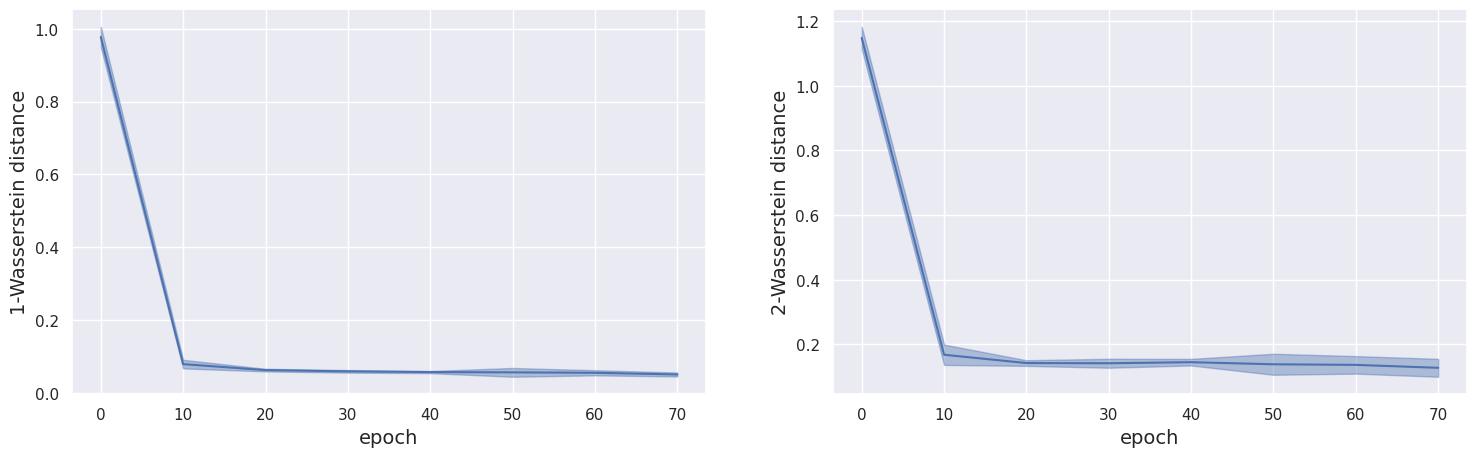

In [14]:
import seaborn as sns
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

x = np.arange(0, 80, 10)

ax[0].plot(x, w1s_mean)
ax[0].fill_between(x, w1s_mean - w1s_std, w1s_mean + w1s_std, color='C0', alpha=0.4)
ax[0].set_xlabel('epoch', fontsize=14)
ax[0].set_ylabel('1-Wasserstein distance', fontsize=14)

ax[1].plot(x, w2s_mean)
ax[1].fill_between(x, w2s_mean - w2s_std, w2s_mean + w2s_std, color='C0', alpha=0.4)
ax[1].set_xlabel('epoch', fontsize=14)
ax[1].set_ylabel('2-Wasserstein distance', fontsize=14)
plt.show()

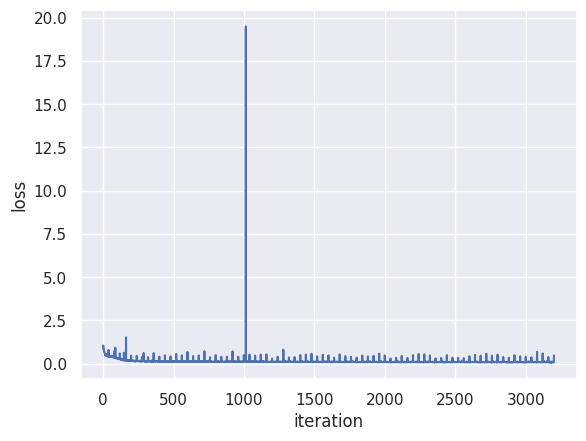

In [15]:
plt.plot(losses_runs[0])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

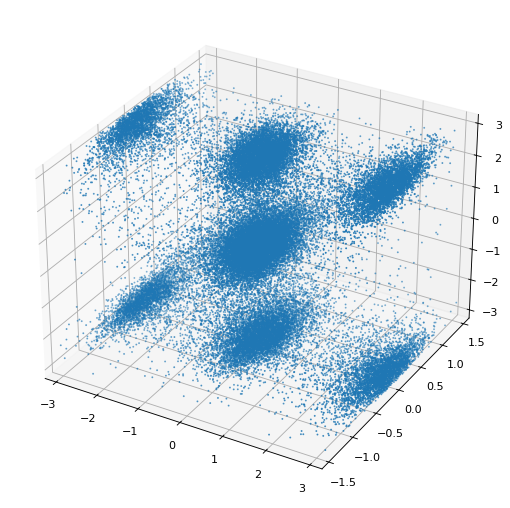

In [16]:
# inference on the full dataset for visualization
plt.style.use('default')
n_test = data.shape[0]
traj = torch.tensor(Rotation.random(n_test).as_matrix()).to(device).reshape(-1, 9)
for t in torch.linspace(0, 1, 200):
    t = torch.tensor([t]).to(device).repeat(n_test)
    dt = torch.tensor([1/200]).to(device)
    traj = inference(model, traj, t, dt)
final_traj = rearrange(traj, 'b (c d) -> b c d', c=3, d=3)
fig = plot_so3(final_traj)
plt.show()